# Forecasting with an RNN

## Setup

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [22]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

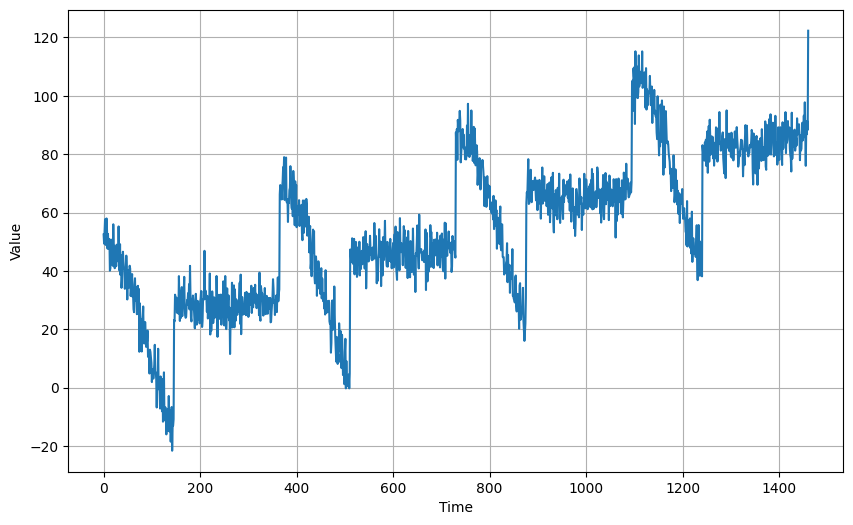

In [23]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [24]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 43ms/step - loss: 45.8941 - mae: 46.3926 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 32.0548 - mae: 32.5504 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 45ms/step - loss: 27.5356 - mae: 28.0309 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 50ms/step - loss: 23.4013 - mae: 23.8973 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 46ms/step - loss: 20.2885 - mae: 20.7815 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 44ms/step - loss: 18.0717 - mae: 18.5647 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 16.5186 - mae: 17.0066 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 39ms/step - loss: 15.2082 - mae: 15.6987 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 47ms/step - loss: 13.9820 - mae: 14.4697 - lr: 2.5

(1e-07, 0.0001, 0.0, 30.0)

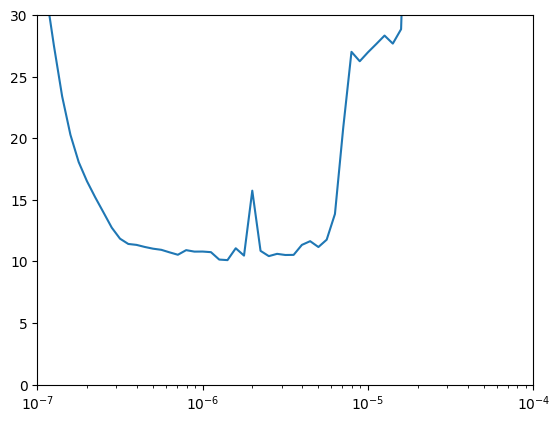

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 4s 41ms/step - loss: 9154.2803 - mae: 9154.7783

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 13s 1s/step - loss: 9685.4121 - mae: 9685.9111 - val_loss: 8925.8125 - val_mae: 8926.3125
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 10602.7285 - mae: 10603.2285

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 8s 1s/step - loss: 10602.7285 - mae: 10603.2285 - val_loss: 2009.5059 - val_mae: 2010.0059
Epoch 3/500
8/8 [==============================] - 1s 71ms/step - loss: 10179.9053 - mae: 10180.4043 - val_loss: 6032.6123 - val_mae: 6033.1123
Epoch 4/500
8/8 [==============================] - 1s 81ms/step - loss: 10304.9307 - mae: 10305.4307 - val_loss: 5848.8384 - val_mae: 5849.3384
Epoch 5/500
8/8 [==============================] - 1s 75ms/step - loss: 10219.3682 - mae: 10219.8682 - val_loss: 9651.3350 - val_mae: 9651.8350
Epoch 6/500
8/8 [==============================] - 1s 71ms/step - loss: 10548.2822 - mae: 10548.7822 - val_loss: 13397.5967 - val_mae: 13398.0967
Epoch 7/500
8/8 [==============================] - 1s 76ms/step - loss: 10745.7773 - mae: 10746.2773 - val_loss: 15389.5166 - val_mae: 15390.0166
Epoch 8/500
8/8 [==============================] - 1s 71ms/step - loss: 11053.2939 - mae: 11053.7939 - val_loss: 51261.3086 - val_mae: 51261.8086


INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 8s 1s/step - loss: 24577.2715 - mae: 24577.7734 - val_loss: 1770.9779 - val_mae: 1771.4779
Epoch 39/500
8/8 [==============================] - 1s 85ms/step - loss: 17719.7480 - mae: 17720.2480 - val_loss: 25938.8418 - val_mae: 25939.3438
Epoch 40/500
8/8 [==============================] - 1s 69ms/step - loss: 20257.0840 - mae: 20257.5859 - val_loss: 36382.6328 - val_mae: 36383.1328
Epoch 41/500
8/8 [==============================] - 1s 77ms/step - loss: 21049.7578 - mae: 21050.2598 - val_loss: 39705.6562 - val_mae: 39706.1562
Epoch 42/500
8/8 [==============================] - 1s 81ms/step - loss: 22571.1719 - mae: 22571.6699 - val_loss: 31120.3477 - val_mae: 31120.8477
Epoch 43/500
8/8 [==============================] - 1s 74ms/step - loss: 21644.7012 - mae: 21645.2012 - val_loss: 28448.7578 - val_mae: 28449.2578
Epoch 44/500
8/8 [==============================] - 1s 78ms/step - loss: 20937.5059 - mae: 20938.0059 - val_loss: 32659.2852 - val_mae:

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 7s 1s/step - loss: 20859.0566 - mae: 20859.5566 - val_loss: 28.1955 - val_mae: 28.6931
Epoch 51/500
8/8 [==============================] - 1s 74ms/step - loss: 46789.2539 - mae: 46789.7500 - val_loss: 62606.1250 - val_mae: 62606.6250
Epoch 52/500
8/8 [==============================] - 1s 69ms/step - loss: 58263.3984 - mae: 58263.8984 - val_loss: 12836.4521 - val_mae: 12836.9521
Epoch 53/500
8/8 [==============================] - 1s 90ms/step - loss: 32734.6836 - mae: 32735.1836 - val_loss: 77951.2500 - val_mae: 77951.7500
Epoch 54/500
8/8 [==============================] - 1s 75ms/step - loss: 63758.0547 - mae: 63758.5508 - val_loss: 29263.0020 - val_mae: 29263.5039
Epoch 55/500
8/8 [==============================] - 1s 67ms/step - loss: 20123.2207 - mae: 20123.7188 - val_loss: 40298.3945 - val_mae: 40298.8945
Epoch 56/500
8/8 [==============================] - 1s 75ms/step - loss: 56090.2305 - mae: 56090.7305 - val_loss: 118404.1641 - val_mae: 11

In [28]:
model = keras.models.load_model("my_checkpoint")

In [29]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


## Simple Mechanized RNN Forecasting

In [30]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
8/8 [==============================] - 2s 24ms/step - loss: 133.7045 - mae: 134.2044 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 97.4661 - mae: 97.9648 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 46.9933 - mae: 47.4938 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 25.7778 - mae: 26.2721 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 26.7366 - mae: 27.2297 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 20.0905 - mae: 20.5832 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 17.9564 - mae: 18.4518 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 15.0914 - mae: 15.5835 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 21ms

(1e-07, 0.0001, 0.0, 30.0)

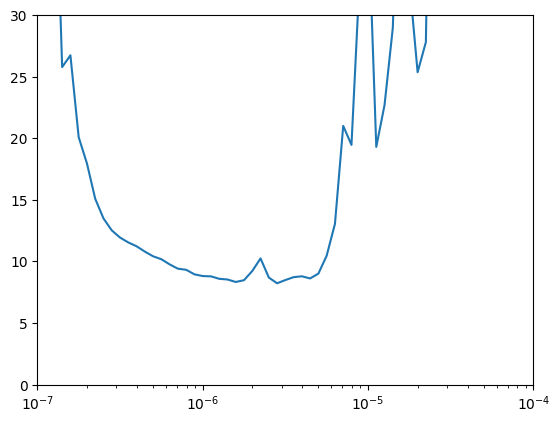

In [32]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint", save_best_only=True)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, gaussian_model_checkpoint])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
      6/Unknown - 1s 24ms/step - loss: 19222.1230 - mae: 19222.6230In Gaussian Mechanism


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 4s 428ms/step - loss: 15458.5479 - mae: 15459.0479 - val_loss: 35989.0195 - val_mae: 35989.5195
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 23650.2148 - mae: 23650.7148

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 2s 335ms/step - loss: 24247.7578 - mae: 24248.2598 - val_loss: 8320.5107 - val_mae: 8321.0117
Epoch 3/500
7/8 [=========================>....] - ETA: 0s - loss: 18777.8594 - mae: 18778.3613

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 2s 322ms/step - loss: 20096.3242 - mae: 20096.8242 - val_loss: 4270.2529 - val_mae: 4270.7554
Epoch 4/500
8/8 [==============================] - 0s 32ms/step - loss: 23675.0273 - mae: 23675.5254 - val_loss: 81262.3125 - val_mae: 81262.8203
Epoch 5/500
8/8 [==============================] - 0s 38ms/step - loss: 71767.2500 - mae: 71767.7500 - val_loss: 35343.8555 - val_mae: 35344.3555
Epoch 6/500
7/8 [=========================>....] - ETA: 0s - loss: 23759.7637 - mae: 23760.2637

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 377ms/step - loss: 25202.8164 - mae: 25203.3203 - val_loss: 4190.7417 - val_mae: 4191.2451
Epoch 7/500
8/8 [==============================] - 0s 31ms/step - loss: 65854.6953 - mae: 65855.1953 - val_loss: 55693.8086 - val_mae: 55694.3125
Epoch 8/500
8/8 [==============================] - 0s 34ms/step - loss: 30111.2500 - mae: 30111.7520 - val_loss: 32545.6582 - val_mae: 32546.1582
Epoch 9/500
8/8 [==============================] - 0s 31ms/step - loss: 22030.7285 - mae: 22031.2188 - val_loss: 13505.4150 - val_mae: 13505.9150
Epoch 10/500
8/8 [==============================] - 0s 32ms/step - loss: 19837.9902 - mae: 19838.4863 - val_loss: 20697.3691 - val_mae: 20697.8691
Epoch 11/500
8/8 [==============================] - 0s 32ms/step - loss: 18947.9375 - mae: 18948.4375 - val_loss: 27493.6016 - val_mae: 27494.0996
Epoch 12/500
8/8 [==============================] - 0s 32ms/step - loss: 42242.5664 - mae: 42243.0664 - val_loss: 14303.0078 - val_mae:

In [34]:
gaussian_model = keras.models.load_model("gaussian_model_checkpoint")

In [35]:
gaussian_rnn_forecast = model_forecast(
    gaussian_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 4ms/step


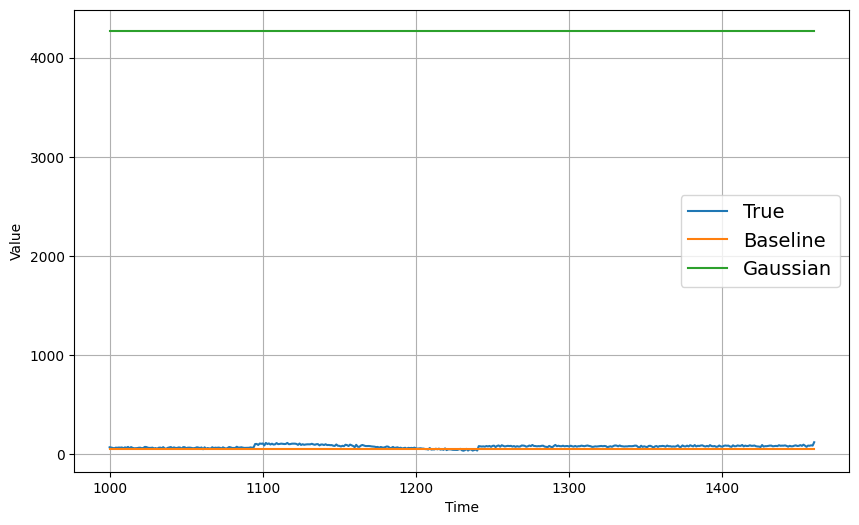

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [37]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

27.837313

In [38]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

4192.0576

## Sequence-to-Sequence Forecasting

In [39]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [40]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 25ms/step - loss: 23.1059 - mae: 23.5987 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 20.9469 - mae: 21.4430 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 19.7287 - mae: 20.2245 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 18.3081 - mae: 18.8026 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 17.0049 - mae: 17.4984 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 15.8248 - mae: 16.3182 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 14.7114 - mae: 15.2045 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 13.7393 - mae: 14.2295 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 22ms/step - loss: 12.8412 - mae: 13.3301 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

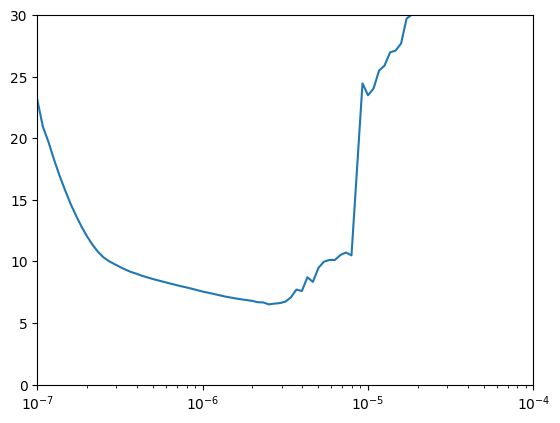

In [42]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 78ms/step - loss: 16157.9043 - mae: 16158.4033 - val_loss: 21739.0781 - val_mae: 21739.5820
Epoch 2/500
8/8 [==============================] - 0s 37ms/step - loss: 11751.3643 - mae: 11751.8643 - val_loss: 12641.1504 - val_mae: 12641.6504
Epoch 3/500
8/8 [==============================] - 0s 37ms/step - loss: 25484.0234 - mae: 25484.5234 - val_loss: 76925.3281 - val_mae: 76925.8203
Epoch 4/500
8/8 [==============================] - 0s 37ms/step - loss: 70320.9453 - mae: 70321.4453 - val_loss: 42010.4844 - val_mae: 42010.9844
Epoch 5/500
8/8 [==============================] - 0s 37ms/step - loss: 26277.8496 - mae: 26278.3516 - val_loss: 2526.8225 - val_mae: 2527.3223
Epoch 6/500
8/8 [==============================] - 0s 36ms/step - loss: 64762.5156 - mae: 64763.0156 - val_loss: 45918.2812 - val_mae: 45918.7812
Epoch 7/500
8/8 [==============================] - 0s 36ms/step - loss: 31590.7930 - mae: 31591.2949 - val_loss: 34125.2070 - 

In [44]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 4ms/step


## Mechanized Sequence-to-Sequence Forecast 

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
8/8 [==============================] - 2s 25ms/step - loss: 98.5047 - mae: 99.0044 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 49.1652 - mae: 49.6639 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 31.0410 - mae: 31.5383 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 26.3307 - mae: 26.8264 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 23.6631 - mae: 24.1577 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 20.4086 - mae: 20.9008 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 18.4465 - mae: 18.9370 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 17.0208 - mae: 17.5082 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 24ms/s

(1e-07, 0.0001, 0.0, 30.0)

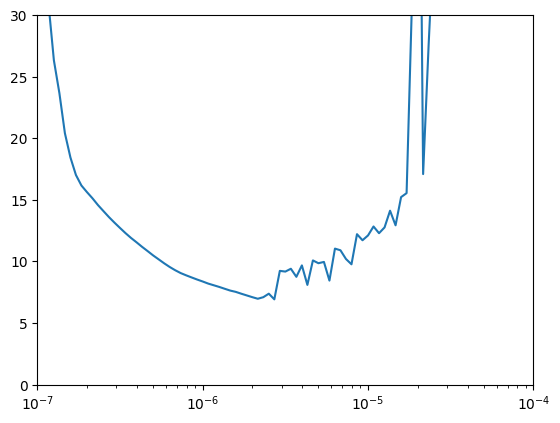

In [47]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
      8/Unknown - 2s 25ms/step - loss: 18683.8516 - mae: 18684.3555In Gaussian Mechanism
8/8 [==============================] - 2s 82ms/step - loss: 18683.8516 - mae: 18684.3555 - val_loss: 35774.8320 - val_mae: 35775.3320
Epoch 2/500
8/8 [==============================] - 0s 34ms/step - loss: 22545.7520 - mae: 22546.2539 - val_loss: 26356.8691 - val_mae: 26357.3652
Epoch 3/500
8/8 [==============================] - 0s 36ms/step - loss: 20889.0156 - mae: 20889.5117 - val_loss: 25504.3574 - val_mae: 25504.8633
Epoch 4/500
8/8 [==============================] - 0s 38ms/step - loss: 21878.9160 - mae: 21879.4141 - val_loss: 19594.9160 - val_mae: 19595.4160
Epoch 5/500
8/8 [==============================] - 0s 35ms/step - loss: 20362.8320 - mae: 20363.3359 - val_loss: 17932.4414 - val_mae: 17932.9453
Epoch 6/500
8/8 [==============================] - 0s 35ms/step - loss: 20971.6328 - mae: 20972.1309 - val_loss: 12246.4199 - val_mae: 12

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

gaussian_rnn_forecast = model_forecast(gaussian_model, series[..., np.newaxis], window_size)
gaussian_rnn_forecast = gaussian_rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()